In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка обучающих данных

In [ ]:
from pathlib import Path
dir = Path("drive/MyDrive/Deep Learning School/Олимпиада ДЛС/Задачи/Финал/сегментация вотермарок/")

In [ ]:
with open(dir / "train_mask_bool.npy", "rb") as f:
    train_mask = np.load(f)
with open(dir / "train_corrupted_images.npy", "rb") as f:
    train_corrupted_images = np.load(f)

In [ ]:
print(train_mask.shape)
print(train_corrupted_images.shape)

(4000, 128, 128)
(4000, 128, 128, 3)


Всего в обучающем множестве 4000 изображений размера $128\times 128\times 3$. Визуализируем по одному примеру из `train_true_images` и `train_corrupted_images`

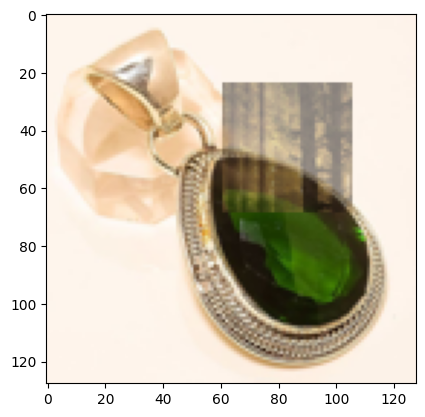

In [ ]:
plt.imshow(train_corrupted_images[10])

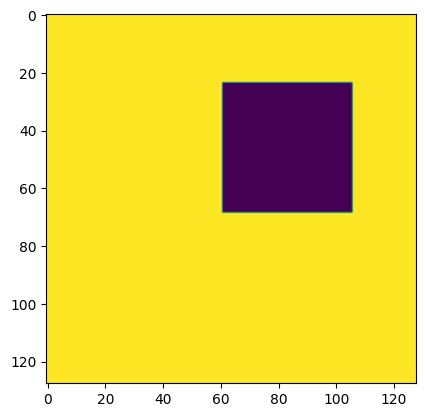

In [ ]:
plt.imshow(train_mask[10])

In [ ]:
train_mask[10]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Видим, что `corrupted_image` содержит вотермарку. Маска имеет следующий вид: `True` соответствует пикселям изображения, `False` --- пикселям вотермарки.

## Метрика
В качестве метрики используется метрика IoU.
$$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup \text{prediction }}.$$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Обратите внимание, что мы детектируем именно вотермарки, поэтому для подсчёта метрики лейблы нужно заменить на противоположные.

Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou(true_mask, pred_mask):
    """
    true_mask[batch_size, 128, 128]: bool np.array
    pred_mask[batch_size, 128, 128]: bool np.array
    """
    assert true_mask.shape[1:] == (128, 128) or true_mask.shape[1:] == (224, 224), 'Check true_mask shape'
    assert pred_mask.shape[1:] == (128, 128) or pred_mask.shape[1:] == (224, 224), 'Check pred_mask shape'
    assert true_mask.shape == pred_mask.shape, 'Mask shapes do not align'

    intersection = ((1 - true_mask.astype(int)) & (1 - pred_mask.astype(int))).sum(axis=(1,2))
    union = ((1 - true_mask.astype(int)) | (1 - pred_mask.astype(int))).sum(axis=(1,2))

    return np.mean(intersection / union)

In [ ]:
# example usage

iou(train_mask, train_mask),\
iou(train_mask, np.ones_like(train_mask, dtype=bool)),\
iou(train_mask, np.zeros_like(train_mask, dtype=bool)),\
iou(train_mask, train_mask * np.random.randint(2, size=train_mask.shape)).round(5)

(1.0, 0.0, 0.09601129150390625, 0.17403)

In [ ]:
# iou for one element

iou(train_mask[10:11], train_mask[10:11] * np.random.randint(2, size=train_mask[10:11].shape)).round(5)

0.21788

In [ ]:
import cv2

array([[[254, 245, 236],
        [254, 245, 236],
        [254, 245, 236],
        ...,
        [253, 243, 233],
        [253, 243, 233],
        [253, 243, 233]],

       [[254, 245, 236],
        [254, 245, 236],
        [254, 245, 236],
        ...,
        [253, 243, 233],
        [253, 243, 233],
        [253, 243, 233]],

       [[254, 245, 236],
        [254, 245, 236],
        [254, 245, 236],
        ...,
        [253, 243, 234],
        [253, 243, 234],
        [253, 243, 234]],

       ...,

       [[254, 244, 235],
        [254, 244, 235],
        [254, 244, 235],
        ...,
        [252, 242, 232],
        [252, 242, 232],
        [252, 242, 232]],

       [[254, 244, 235],
        [254, 244, 235],
        [254, 244, 235],
        ...,
        [252, 242, 232],
        [252, 242, 232],
        [252, 242, 232]],

       [[254, 244, 235],
        [254, 244, 235],
        [254, 244, 235],
        ...,
        [252, 242, 232],
        [252, 242, 232],
        [252, 242, 232]]], dtype=uint8)
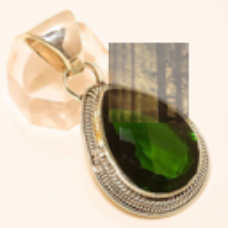

In [ ]:
cv2.resize(train_corrupted_images[10], (228, 228))

In [ ]:
def resize_one_mask(mask):
    return cv2.resize(mask[:, :, None] * np.ones((1, 1, 3)), (224,224))[:, :, 0].round()

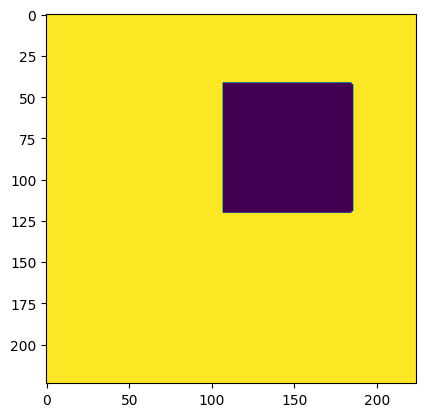

In [ ]:
plt.imshow(resize_one_mask(train_mask[10]))

In [ ]:
train_images_resized = np.stack([cv2.resize(image, (224, 224)) for image in train_corrupted_images])
train_images_resized.shape

(4000, 224, 224, 3)

In [ ]:
train_mask_resized = np.stack([resize_one_mask(mask) for mask in train_mask])
train_mask_resized.shape

(4000, 224, 224)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
def get_coords(mask):
    """
    mask: 224x224
    """
    y_min = np.nonzero(np.sum(mask, axis=1) < 224)[0][0]
    x_min = np.nonzero(np.sum(mask, axis=0) < 224)[0][0]
    y_max = np.nonzero(np.sum(mask, axis=1) < 224)[0][-1]
    return {
        "y_min": y_min,
        "x_min": x_min,
        "delta": y_max - y_min
    }

In [ ]:
class ImageSegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = torch.tensor(images).float()
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        coords = get_coords(self.masks[idx])
        return {
            "image": self.images[idx].permute(2, 0, 1),
            "y_min": torch.tensor(coords["y_min"]),
            "x_min": torch.tensor(coords["x_min"]),
            "delta": torch.tensor(coords["delta"]),
            "mask": self.masks[idx]
        }

In [ ]:
from sklearn.model_selection import train_test_split
learn_images_resized, val_images_resized, learn_mask_resized, val_mask_resized = train_test_split(train_images_resized, train_mask_resized, train_size=0.8)

In [ ]:
train_dataset = ImageSegmentationDataset(learn_images_resized, learn_mask_resized)
train_dl = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = ImageSegmentationDataset(val_images_resized, val_mask_resized)
val_dl = DataLoader(train_dataset, batch_size=4, shuffle=False)

batch = next(iter(train_dl))
batch

{'image': tensor([[[[164., 165., 166.,  ..., 150., 149., 149.],
           [164., 164., 165.,  ..., 150., 150., 150.],
           [164., 164., 165.,  ..., 151., 151., 151.],
           ...,
           [184., 170., 148.,  ..., 173., 170., 168.],
           [146., 139., 129.,  ..., 174., 173., 173.],
           [122., 120., 117.,  ..., 175., 175., 176.]],
 
          [[196., 197., 198.,  ..., 186., 186., 186.],
           [196., 196., 197.,  ..., 187., 186., 186.],
           [196., 196., 197.,  ..., 188., 187., 187.],
           ...,
           [183., 170., 147.,  ..., 154., 150., 148.],
           [145., 139., 129.,  ..., 155., 154., 154.],
           [122., 120., 117.,  ..., 155., 156., 157.]],
 
          [[212., 212., 212.,  ..., 208., 207., 207.],
           [212., 212., 212.,  ..., 208., 207., 207.],
           [211., 211., 212.,  ..., 208., 207., 207.],
           ...,
           [185., 171., 148.,  ..., 143., 141., 140.],
           [145., 138., 129.,  ..., 144., 144., 145.],
  

In [ ]:
get_coords(learn_mask_resized[0])

{'y_min': 121, 'x_min': 10, 'delta': 78}

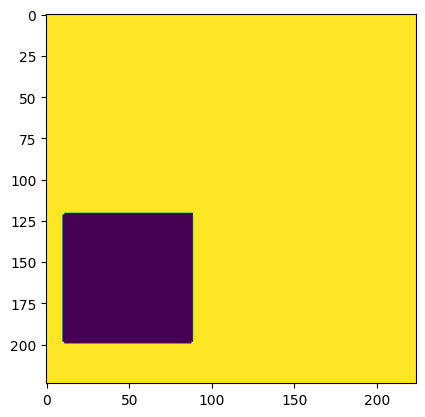

In [ ]:
plt.imshow(learn_mask_resized[0])

In [ ]:
def get_mask(y_min, x_min, delta, img_size):
    """
    param y_min: [batch_size]
    param x_min: [batch_size]
    param delta: [batch_size]

    returns masks: [batch_size,img_size,img_size]
    """
    masks = []
    for y_min_value, x_min_value, delta_value in zip(y_min, x_min, delta):
        y_min_value = int(round(min(img_size, max(0, y_min_value))))
        x_min_value = int(round(min(img_size, max(0, x_min_value))))
        delta_value = int(round(min(img_size, max(0, delta_value))))

        mask = np.ones((img_size, img_size), dtype=bool)
        mask[y_min_value:y_min_value + delta_value, x_min_value:x_min_value+delta_value] = False
        masks.append(mask)
    return np.stack(masks)

In [ ]:
coords = get_coords(learn_mask_resized[0])

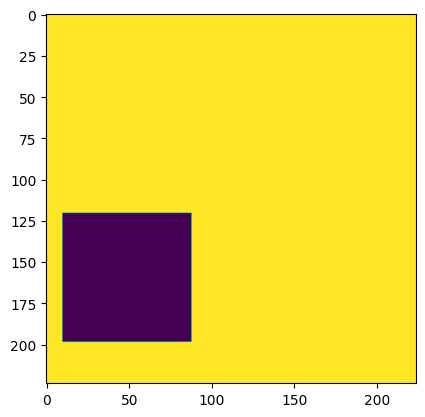

In [ ]:
obtained_mask = get_mask([coords["y_min"]], [coords["x_min"]], [coords["delta"]], 224)
plt.imshow(obtained_mask[0])

In [ ]:
def eval(loader):
    losses = []
    ious = []

    for j, batch in tqdm(enumerate(loader), "eval cycle"):
        with torch.no_grad():
            output = model(batch["image"].to(model.fc.weight))

        loss = torch.mean(
            (output[:, 0] - batch["y_min"].to(output))**2 +
            (output[:, 1] - batch["x_min"].to(output))**2 +
            (output[:, 2] - batch["delta"].to(output))**2
        )

        losses.append(loss.item())
        pred_mask = get_mask(
            output[:, 0].cpu().numpy(),
            output[:, 1].cpu().numpy(),
            output[:, 2].cpu().numpy(),
            img_size=batch["mask"].shape[1]
        )
        ious.append(iou(batch["mask"].numpy(), pred_mask))
    return np.mean(losses), np.mean(ious)

In [ ]:
from tqdm import tqdm
from IPython import display
from torch import nn
from torchvision.models import resnet50

In [ ]:
model = resnet50(pretrained=True).to("cuda")
model.fc = nn.Linear(2048, 3).to("cuda")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses = []
batch_size = 64
n_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_dataset) // batch_size + 1,
    epochs=n_epochs
)

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

current train loss: 12.085255432128907
Current val loss: 125.61951241126427


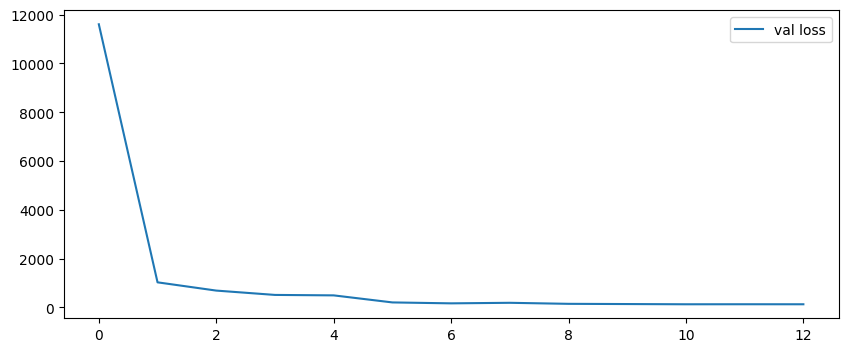

Current val iou: 0.835328176218112


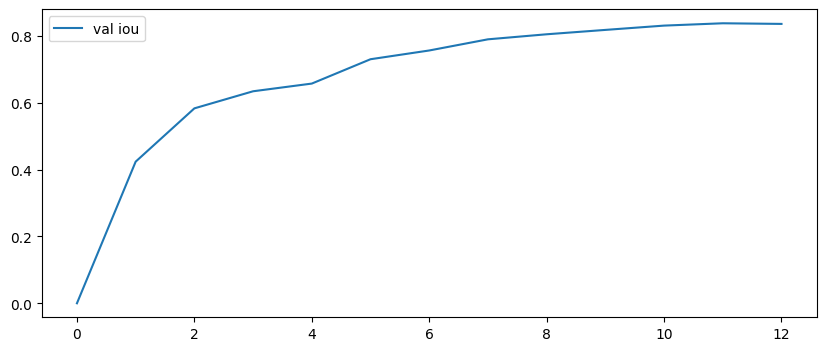

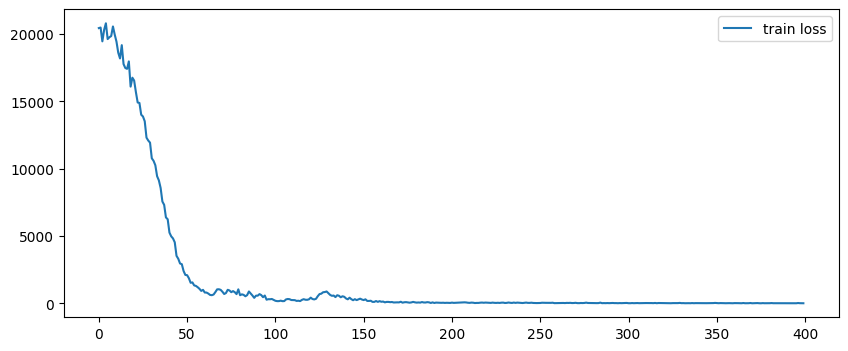

50it [00:33,  1.48it/s]


In [ ]:
losses = []
mean_losses = []
val_losses = []
val_ious = []

for i in range(n_epochs):
    for j, batch in tqdm(enumerate(train_dl)):
        optimizer.zero_grad()
        output = model(batch["image"].to(model.fc.weight))

        loss = torch.mean(
            (output[:, 0] - batch["y_min"].to(output))**2 +
            (output[:, 1] - batch["x_min"].to(output))**2 +
            (output[:, 2] - batch["delta"].to(output))**2
        )

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

        if (j+1) % 5 == 0:
            display.clear_output(wait=True)
            mean_losses.append(np.mean(losses[-5:]))
            print(f"current train loss: {mean_losses[-1]}")
            if len(val_losses) > 0:
                print(f"Current val loss: {val_losses[-1]}")
                plt.figure(figsize=(10,4))
                plt.plot(val_losses, label="val loss")
                plt.legend()
                plt.show()

                print(f"Current val iou: {val_ious[-1]}")
                plt.figure(figsize=(10,4))
                plt.plot(val_ious, label="val iou")
                plt.legend()
                plt.show()

            plt.figure(figsize=(10,4))
            plt.plot(mean_losses, label="train loss")
            plt.legend()
            plt.show()

    if (i+1) % 3 == 0:
        val_loss, val_iou = eval(val_dl)
        val_losses.append(val_loss)
        val_ious.append(val_iou)

## Загрузка тестовых данных

In [ ]:
with open(dir / "test_corrupted_images.npy", "rb") as f:
    test_corrupted_images = np.load(f)

test_corrupted_images.shape

(2000, 128, 128, 3)

In [ ]:
test_images_resized = np.stack([cv2.resize(image, (224, 224)) for image in test_corrupted_images])
test_dataset = ImageSegmentationDataset(
    test_images_resized,
    np.zeros(test_images_resized.shape[:3], dtype=bool)
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
pred_masks = []
for j, batch in tqdm(enumerate(test_loader), "test cycle"):
    with torch.no_grad():
        output = model(batch["image"].to(model.fc.weight))

    pred_mask = get_mask(
        output[:, 0].cpu().numpy() * 128 / 224,
        output[:, 1].cpu().numpy() * 128 / 224,
        output[:, 2].cpu().numpy() * 128 / 224,
        img_size=128
    )
    pred_masks.append(pred_mask)

test cycle: 32it [00:07,  4.08it/s]


In [ ]:
pred_masks = np.concatenate(pred_masks)

Всего 2000 изрбражений в тестовом множестве, все с вотермарками.

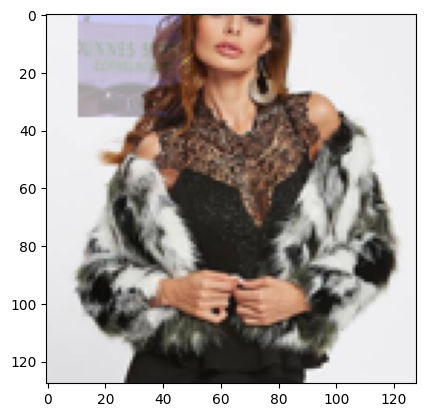

In [ ]:
plt.imshow(test_corrupted_images[10])

Массив `test_classes` содержит предсказания того, что соответствующий пиксель данной картинки --- настоящий, а не "испорчен" вотермаркой. `True` означает "картинка", `False` означает "вотермарка".

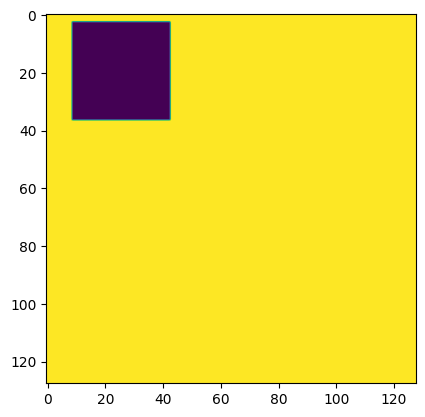

In [ ]:
plt.imshow(pred_masks[10])

In [ ]:
with open(dir / "test_mask_bool.npy", "rb") as f:
    test_mask = np.load(f)

In [ ]:
pred_mask.shape, test_mask.shape

((16, 128, 128), (2000, 128, 128))

In [ ]:
iou(test_mask, pred_masks)

0.8489174760718674

Сохраним предсказания в sample_submission.

In [ ]:
with open("data/sample_submission_segmentation.npy", "wb") as f:
    np.save(f, test_mask, allow_pickle=False)

In [ ]:
torch.save(model, dir / "model.pt")